# Digit Recognition

Build a deep learning model to classify handwritten digits. You can use convolutional neural networks (CNNs) or other machine learning algorithms for this task.

In [1]:
# Importing necessary libraries for PyTorch and data visualization
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


## Preparing the dataset

In [2]:
# Create useful folders
# folders = ["../data", "../results/", "../results/digit-recognition/"]
folders = ["../data"]
for f in folders:
    if not os.path.exists(f):
        os.mkdir(f)

In [3]:
# Defining batch sizes for training and testing data
batch_size_train = 64
batch_size_test = 1000
# Defining data transformations, including converting images to tensors and normalizing pixel values
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
# Loading MNIST dataset for training and testing
# For training data, setting train=True, downloading if not available, and applying transformations
train_dataset = datasets.MNIST("../data", train=True, download=True, transform=transform)
# For testing data, setting train=False, not downloading, and applying transformations
test_dataset = datasets.MNIST("../data", train=False, transform=transform)
# Creating data loaders for efficient batch processing during training and testing
# For training data, using DataLoader with specified batch size and shuffling the data
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)
# For testing data, using DataLoader with specified batch size and shuffling the data
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size_test, shuffle=True
)

In [4]:
# # Getting one batch of examples from the test_loader
# batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

# # Printing the shape of the example_data tensor
# print("Shape of example_data:", example_data.shape)

# # Plotting the first images along with their labels
# fig, axes = plt.subplots(5, 5, figsize=(10, 15))

# for i, ax in enumerate(axes.flat):
#     ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
#     ax.set_title("{}".format(example_targets[i]))
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

## Building the network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=3136, out_features=128, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=128, out_features=10, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        output = F.log_softmax(x, dim=1)
        return output

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

# net = Net()
# input_data = torch.randn(13, 1, 28, 28)
# output_data = net(input_data)
# print("La taille de sortie :", output_data.size())

In [6]:
learning_rate = 0.001
n_epochs = 3
train_losses = []
model = Net()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
)


## Training the model

In [7]:
log_interval = 100
n1 = len(train_loader.dataset)
n2 = len(train_loader)

torch.autograd.set_detect_anomaly(True)

def train(epoch):
    """
    Training function for the neural network model.

    Args:
        epoch (int): Current epoch number.
    """
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Print training progress and store losses
        if batch_idx % log_interval == 0:
            print(
                "Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    n1,
                    100.0 * batch_idx / n2,
                    loss.item(),
                )
            )
            train_losses.append(loss.item())
    # Save model and optimizer states at the end of each epoch
    # torch.save(model.state_dict(), '../results/digit-recognition/model_epoch_{}.pth'.format(epoch))
    # torch.save(optimizer.state_dict(), '../results/digit-recognition/optimizer_epoch_{}.pth'.format(epoch))


def test():
    """
    Evaluation function for the neural network model on the test set.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)  # Forward pass
            test_loss += criterion(output, target).item()  # Calculate the loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the predicted labels
            correct += (
                pred.eq(target.view_as(pred)).sum().item()
            )  # Count correct predictions

    test_loss /= len(test_loader.dataset)
    # Print test set results
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [8]:
# Training and testing loop
for epoch in range(1, n_epochs + 1):
    train(epoch)  # Train the model for the current epoch
    test()  # Evaluate the model on the test set after training

Epoch: 1 [0/60000 (0%)]	Loss: 2.382823
Epoch: 1 [6400/60000 (11%)]	Loss: 0.904301
Epoch: 1 [12800/60000 (21%)]	Loss: 0.822275
Epoch: 1 [19200/60000 (32%)]	Loss: 0.399244
Epoch: 1 [25600/60000 (43%)]	Loss: 1.066694
Epoch: 1 [32000/60000 (53%)]	Loss: 0.433304
Epoch: 1 [38400/60000 (64%)]	Loss: 0.757584
Epoch: 1 [44800/60000 (75%)]	Loss: 0.537451
Epoch: 1 [51200/60000 (85%)]	Loss: 0.527968
Epoch: 1 [57600/60000 (96%)]	Loss: 0.563847

Test set: Average loss: 0.0001, Accuracy: 9811/10000 (98.11%)

Epoch: 2 [0/60000 (0%)]	Loss: 0.630295
Epoch: 2 [6400/60000 (11%)]	Loss: 0.549511
Epoch: 2 [12800/60000 (21%)]	Loss: 0.607276
Epoch: 2 [19200/60000 (32%)]	Loss: 0.421983
Epoch: 2 [25600/60000 (43%)]	Loss: 0.281447
Epoch: 2 [32000/60000 (53%)]	Loss: 0.508453
Epoch: 2 [38400/60000 (64%)]	Loss: 0.435872
Epoch: 2 [44800/60000 (75%)]	Loss: 0.339046
Epoch: 2 [51200/60000 (85%)]	Loss: 0.591864
Epoch: 2 [57600/60000 (96%)]	Loss: 0.492137

Test set: Average loss: 0.0001, Accuracy: 9893/10000 (98.93%)

Epoc

## Evaluating the Model's Performance

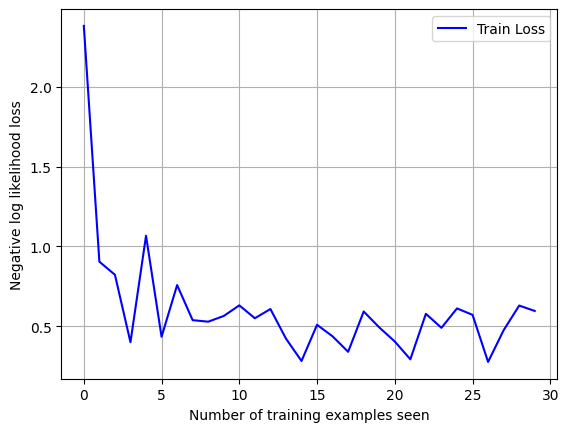

In [9]:
# Create a new figure for plotting
fig = plt.figure()

# Plot training losses as a blue line
plt.plot(train_losses, color="blue")
plt.grid(True)

# Add legend and labels
plt.legend(["Train Loss"], loc="upper right")
plt.xlabel("Number of training examples seen")
plt.ylabel("Negative log likelihood loss")

# Display the plot
plt.show()

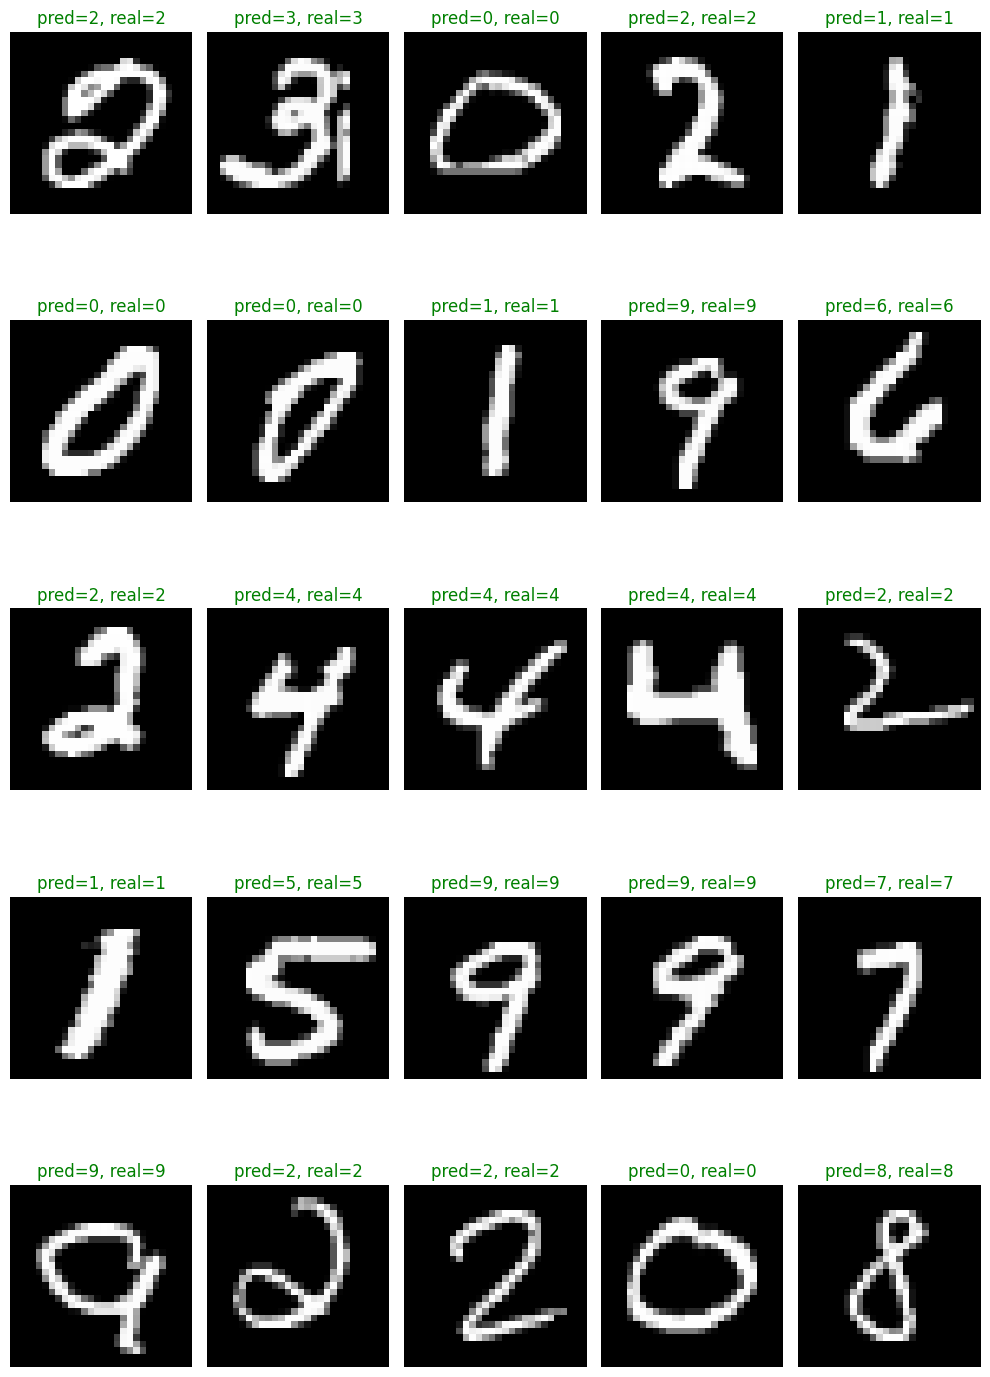

In [10]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))
with torch.no_grad():
    # Disable gradient calculation
    output = model(example_data)  # Forward pass of the model with example_data
    fig, axes = plt.subplots(5, 5, figsize=(10, 15))  # Create a 3x4 grid of subplots
    predictions = output.argmax(dim=1)  # Calculate predictions once

    # Iterate over each subplot
    for i, ax in enumerate(axes.flat):
        ax.imshow(example_data[i][0], cmap="gray", interpolation="none")
        prediction = predictions[i].item()
        target = example_targets[i].item()
        ax.set_title(f"pred={prediction}, real={target}", color='green' if prediction == target else 'red')
        ax.axis('off')  # Hide axis labels

    plt.tight_layout()  # Adjust layout
    plt.show()